In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from joblib import dump as j_dump
import numpy as np
import pickle
import random
import os

In [2]:
# # Uncomment this box if the file is in google drive
# # Create your own directory in your google drive and change path2root var.
# path2root = "/content/drive/MyDrive/Projects/EyeTracker/"

In [2]:
# Uncomment this box if the file is in your local directory
path2root = "../../"

In [3]:
models_fol = "models/"
models_boi_fol = "boi/"
raw_fol = "raw/"
trained_fol = "trained/"
selected_model_num = 1
subjects_fol = "subjects/"
data_boi_fol = "data-boi/"
dataset_fol = "dataset/boi/"
subjects = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
test_sbj = 23
r_train = 0.85
n_epochs = 160
patience = 10
min_brightness_ratio = 0.65
max_brightness_ratio = 1.45

In [4]:
x1_load = []
x2_load = []
y_load = []

subjects_dir = path2root + subjects_fol

for sbj in subjects:
    data_boi_dir = subjects_dir + f"{sbj}/" + data_boi_fol
    with open(data_boi_dir + "x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(data_boi_dir + "x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(data_boi_dir + "y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        if y10 == 0:
            continue
        elif y10 == 2:
            y10 = 0
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_smp, frame_h, frame_w = x1_load.shape[:-1]

print(n_smp, frame_h, frame_w)

80000 100 100


In [5]:
import matplotlib.pyplot as plt

1.0


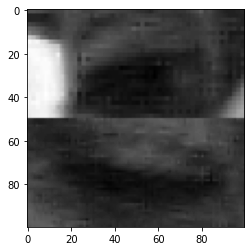

In [10]:
smp_num = 2700
print(y_load[smp_num])
plt.imshow(x1_load[smp_num].reshape((frame_h, frame_w)), cmap="gray")
plt.show()

In [11]:
# changing brightness
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(min_brightness_ratio, max_brightness_ratio)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

del x1_load

In [12]:
x1_shf, x2_shf, y_shf = shuffle(x1_chg_bri, x2_load, y_load)
del x1_chg_bri

In [13]:
x1_scaler = 255.0
x1 = x1_shf / x1_scaler
del x1_shf

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_shf)

scalers = [x1_scaler, x2_scaler]

In [14]:
n_train = int(r_train * n_smp)
n_val = n_smp - n_train
x1_train, x2_train = x1[:n_train], x2[:n_train]
x1_val, x2_val = x1[n_train:], x2[n_train:]
y_train = y_shf[:n_train]
y_val = y_shf[n_train:]

del x1

print(x1_train.shape, x1_val.shape, x2_train.shape, x2_val.shape,
      y_train.shape, y_val.shape)

(68000, 100, 100, 1) (12000, 100, 100, 1) (68000, 10) (12000, 10) (68000,) (12000,)


In [15]:
x_train_list = [x1_train, x2_train]
x_val_list = [x1_val, x2_val]
del x1_train
del x1_val

In [16]:
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

In [17]:
raw_model_dir = path2root + models_fol + models_boi_fol + raw_fol + f"model{selected_model_num}.h5"

model = load_model(raw_model_dir)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 16) 1952        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 32)   25120       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True)

In [ ]:
results = model.fit(x_train_list,
                    y_train_ctg,
                    validation_data=(x_val_list, y_val_ctg),
                    epochs=n_epochs,
                    callbacks=cb)

Epoch 1/160
3188/3188 [==============================] - 704s 203ms/step - loss: 0.2288 - val_loss: 0.1007
Epoch 2/160
3188/3188 [==============================] - 121s 38ms/step - loss: 0.0814 - val_loss: 0.0843
Epoch 3/160
3188/3188 [==============================] - 121s 38ms/step - loss: 0.0560 - val_loss: 0.0616
Epoch 4/160
3188/3188 [==============================] - 121s 38ms/step - loss: 0.0437 - val_loss: 0.0638
Epoch 5/160
3188/3188 [==============================] - 121s 38ms/step - loss: 0.0351 - val_loss: 0.0486
Epoch 6/160
3188/3188 [==============================] - 121s 38ms/step - loss: 0.0283 - val_loss: 0.0671
Epoch 7/160
3188/3188 [==============================] - 121s 38ms/step - loss: 0.0265 - val_loss: 0.0540
Epoch 8/160
 248/3188 [=>............................] - ETA: 1:44 - loss: 0.0262

In [25]:
y_prd_train = model.predict(x_train_list).argmax(1)
y_prd_val = model.predict(x_val_list).argmax(1)

Test
1.0


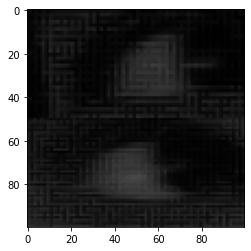

In [50]:
smp_num = 18
print("Test")
print(y_train[smp_num])
# print(y_prd_train[smp_num])
plt.imshow(
    (x1_train[smp_num].reshape((frame_h, frame_w)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

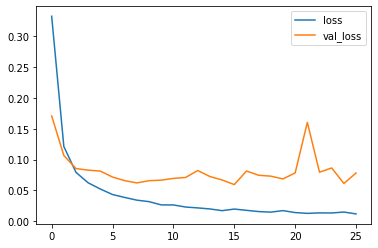

In [81]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

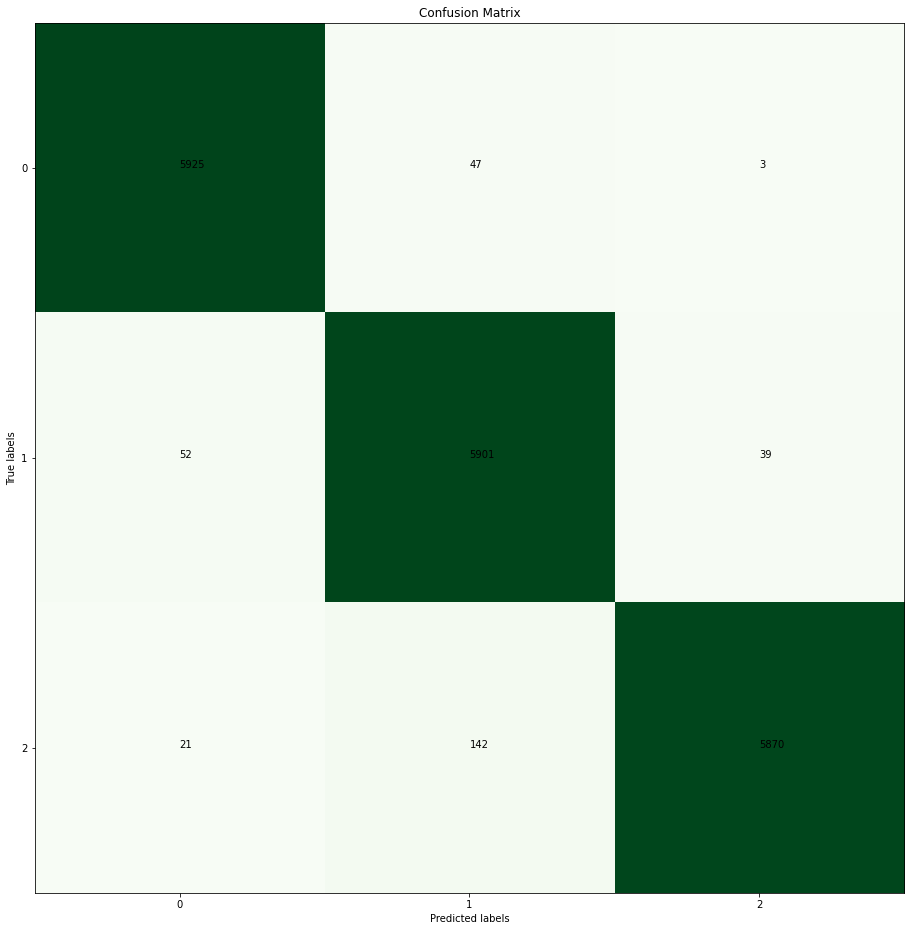

In [26]:
from sklearn.metrics import confusion_matrix

n_class = y_train_ctg.shape[1]
cm_val = confusion_matrix(y_val, y_prd_val)
plt.figure(figsize=(16, 16))
plt.imshow(cm_val, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
    for j in range(n_class):
        plt.text(i, j, cm_val[j][i])

In [10]:
trained_dir = path2root + models_fol + models_boi_fol + trained_fol
if not os.path.exists(trained_dir):
    os.mkdir(trained_dir)

In [11]:
models_numbers = []
models_name = os.listdir(trained_dir)
if models_name:
    for mn in models_name:
        if mn[:5] == "model":
            mn0 = int(mn[5:-3])
            models_numbers.append(mn0)
    max_num = max(models_numbers)
else:
    max_num = 0

model.save(trained_dir + f"model{max_num+1}.h5")
# scalers_dir = path2root + models_fol + models_boi_fol + trained_fol + f"scalers{max_num+1}.bin"
# j_dump(scalers, scalers_dir)